# Pan CoV analysis

## Soup-to-Nuts Notebook

This notebook contains the hit-calling analysis for the Pan-CoV PhIP-Seq Study

1. Cleanup ds & Curate peptides in ds
2. Curate samples in ds
3. Analysis - model fitting
4. FPR Cutoff analysis
5. Hit calling

In [1]:
import phippery
from phippery.normalize import rank_data_table, standardized_enrichment, cpm, size_factors
from phippery.utils import *
from phippery.tidy import tidy_ds
from phippery.modeling import gamma_poisson_model

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as tick
import matplotlib as mpl
from plotnine import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import copy
from functools import reduce
from collections import defaultdict
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Path to raw counts dataset
Caitlin_CoV_path = "../_ignore/pan-cov-ds.phip"

# threshold at which to cut all samples below
tech_rep_thresh = 0.5

# mean pw_cc for which to cut out beads samples for fitting
pw_beads_cc_thresh = 0.3

# library batches
library_batches = ["MEGSUB", "SUB2"]

# False positive rate
fpr = 0.05

# basedir for plots and csv. Everything that's created in this notebook will end up in this dir
plots_csv_basedir = "FPR_05_a08_b01_2"
if not os.path.exists(plots_csv_basedir): os.mkdir(plots_csv_basedir)
    
# metric we're basing the rank and enrichment from, mlxp for now - although it would be trivial
# to do all the same using std-enrichment, cpm, size-factors, or gp-mlxp normalized on cpm.
metric = "gamma_poisson_mlxp_size_factors"

starting_alpha, starting_beta = 0.8, 0.1

## 1. Dataset Cleanup and Peptide Curation

In [3]:
# load the raw counts dataset
ds = pickle.load(open(Caitlin_CoV_path,"rb"))

# we've decided LIB3 == MEGSUB
batch_col = ds.sample_table.loc[:,"library_batch"]
batch_col[batch_col == "LIB3"] = "MEGSUB"

# change some names
prot_col = ds.peptide_table.loc[:,"Protein"]

name_map = {
    "ORF3a_protein" : "ORF3a",
    "ORF6_protein" : "ORF6", 
    "ORF7a_protein" : "ORF7a",
    "ORF8_protein" : "ORF8",
    "replicase_polyprotein_1ab" : "replicase",
    "envelope" : "Envelope",
    "membrane" : "Membrane",
    "nucleocapsid" : "Nucleocapsid",
    "replicase" : "ORF1ab",
    "spike" : "Spike"
}

for old_name, new_name in name_map.items(): 
    prot_col[prot_col == old_name] = new_name

# throw out HIV positive and temporal measures of the same samples.
non_HIV = sample_id_coordinate_subset(ds, "patient_status", is_not_equal_to="hiv pos control")
non_sam_40 = sample_id_coordinate_subset(ds, "sample_ID", is_not_equal_to="40")
non_60 = sample_id_coordinate_subset(ds, "patient_status", is_not_equal_to="conv outpatient 60d")
non_90 = sample_id_coordinate_subset(ds, "patient_status", is_not_equal_to="conv outpatient 90d")
non_hiv_neg = sample_id_coordinate_subset(ds, "patient_status", is_not_equal_to="HIV neg control")
samples_to_keep = set.intersection(set(non_HIV), set(non_60), set(non_90), set(non_hiv_neg), set(non_sam_40))

# we're only keeping a single strain per virus.
strains_to_keep = {
    '229E':'SC0865',
    'HIV1':'BG505',
    'HKU1':'Caen1',
    'MERS,':'KFMC4',
    'NL63,':'ChinaGD01',
    'OC43,':'SC0776',
    'SARS,':'Urbani',
    'SARSCoV2,':'WuhanHu1',
    'batSL,':'CoVZC45'
}

# throw out 
peptides_to_keep = peptide_id_coordinate_subset(ds, where="Strain", is_in=list(strains_to_keep.values()))
ds = ds.loc[dict(sample_id=list(samples_to_keep), peptide_id=peptides_to_keep)]

## 2. Looking at library input sequences

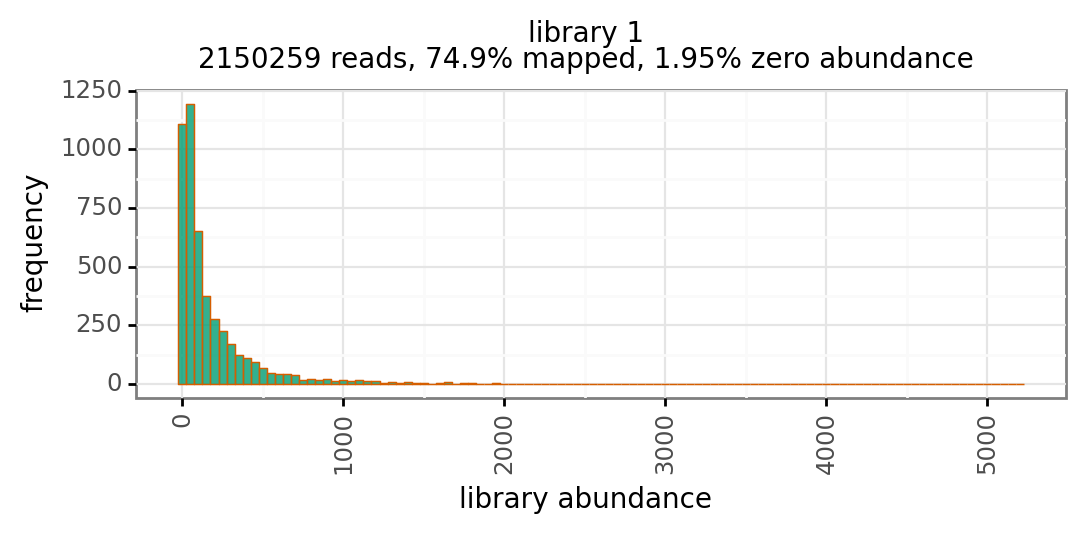

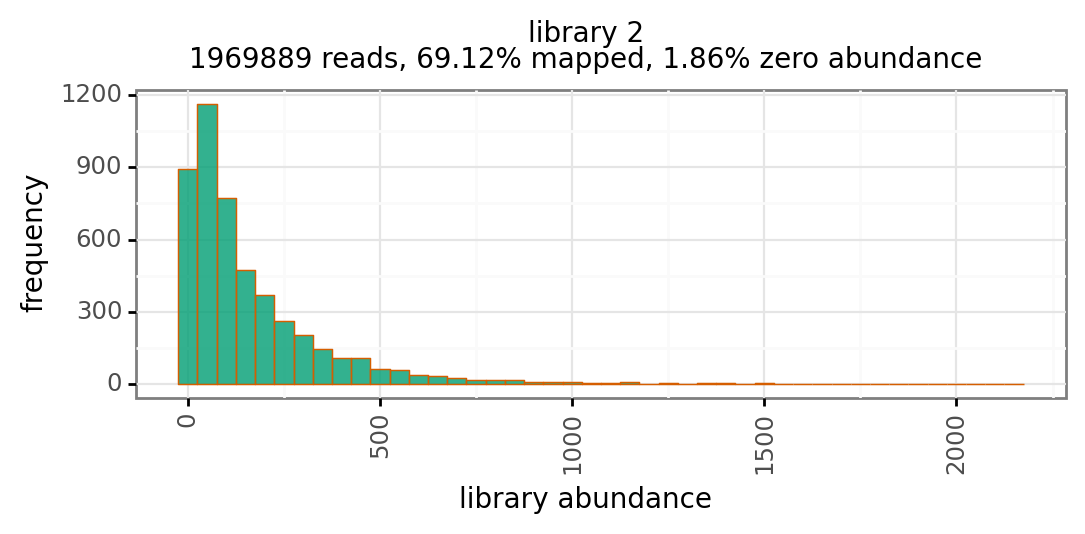

In [4]:
# the two representative input samples and respective sequencing depths + % mapped using samtools flagstat.

lib_1 = {
    "name" : "library 1",
    "sample_id" : 434,
    "total_reads" : 2150259,
    "percent_mapped" : 74.90
}

lib_2 = {
    "name" : "library 2",
    "sample_id" : 388,
    "total_reads" : 1969889,
    "percent_mapped" : 69.12
}

for input_lib in [lib_1, lib_2]:


    library_ds = ds.loc[dict(sample_id=[input_lib["sample_id"]])]
    counts = library_ds.counts.values
    per_zero = round(len(counts[counts == 0]) / len(counts)*100,2)
    tidy_lib = tidy_ds(library_ds)
    
    f = (
        ggplot(tidy_lib, aes(x='counts'))
        + geom_histogram(
            binwidth=50,
            colour="#D55E00",
            fill="#009E73",
            size=0.3,
            alpha=0.8,
            show_legend=False
        )

        + labs(
            title=input_lib["name"] 
                + "\n" 
                + str(input_lib["total_reads"])
                + " reads, " 
                + str(input_lib["percent_mapped"])
                + "% mapped, "
                + str(per_zero) 
                + "% zero abundance",
            y="frequency",
            x="library abundance"
        )
        
        + theme_bw()  
        + theme(
            title=element_text(size=10),
            axis_text_x=element_text(rotation=90), 
            figure_size=[6,2]
        )
    )
    f.save(f"{plots_csv_basedir}/" + input_lib["name"] + ".pdf")
    f.draw()
    

## Curate Samples

In [5]:
# For each of the batches we need to find the correct samples 
# to fit.
top_two_replicates_per_sample = defaultdict(dict)
high_quality_beads_controls = {}
high_quality_library_controls = {}
zero_peptides = {}

# all valid patient samples
valid_patient_status_samples = set(
    sample_id_coordinate_subset(
        ds, where="patient_status", is_valid=True
    )
)

# all the biological samples
all_bio_ds = ds.loc[dict(sample_id=list(valid_patient_status_samples))]
num_bio_samples = len(get_all_sample_metadata_factors(all_bio_ds, "sample_ID"))
print(f"There are {num_bio_samples} biologically distinct samples before curation")

# print the cohorts we have before curation
for batch, batch_ds in iter_sample_groups(all_bio_ds, "library_batch"):
    if batch not in library_batches: continue
    print(f"\n### {batch} ###\n")
    for group, group_ds in iter_sample_groups(batch_ds, "patient_status"):
        n_bio_reps = len(get_all_sample_metadata_factors(group_ds, "sample_ID"))
        print(f"{batch}\t{group} has {len(group_ds.sample_id.values)} bio reps for {n_bio_reps} bio samples")


# grab two high quality biological replicates from each batch, must exist in both
print(f"\nInformation about biological samples\n")
bio_replicates_to_keep = []
megsub_samples = []
for bio_id, bio_ds in iter_sample_groups(all_bio_ds, "sample_ID"):
    samples_above_thresh = sample_id_coordinate_subset(
        bio_ds, where="tech_rep_correlation", is_greater_than=tech_rep_thresh
    )
    bio_ds = bio_ds.loc[dict(sample_id=samples_above_thresh)]
    batches_w_hq_rep = get_all_sample_metadata_factors(bio_ds,"library_batch")
    if "MEGSUB" in batches_w_hq_rep: megsub_samples.append(bio_id)
    print(f"sample_ID {bio_id} has hq replicates in {batches_w_hq_rep}")
    if len(batches_w_hq_rep) < 2: print(f"skipping\n"); continue
    batches = set()
    df = bio_ds.sample_table.to_pandas().reset_index().sort_values(
        by="tech_rep_correlation", ascending=False
    )
    for i, bio_rep in df.iterrows():
        if bio_rep["library_batch"] not in batches:
            batches.add(bio_rep["library_batch"])
            bio_replicates_to_keep.append(bio_rep["sample_id"])
        if len(batches) == 2: break
        
    print(f"including {bio_replicates_to_keep[-2:]} from {batches}\n")

There are 35 biologically distinct samples before curation

### MEGSUB ###

MEGSUB	acute inpatient has 4 bio reps for 4 bio samples
MEGSUB	conv outpatient has 3 bio reps for 3 bio samples
MEGSUB	conv outpatient 30d has 40 bio reps for 18 bio samples
MEGSUB	endemic CoV has 2 bio reps for 1 bio samples
MEGSUB	endemic CoV (HAARVi inpatient) has 1 bio reps for 1 bio samples
MEGSUB	endemic CoV, HRV has 1 bio reps for 1 bio samples
MEGSUB	endemic CoV, RSV, PIV1, HRV (HAARVi inpatient) has 2 bio reps for 1 bio samples
MEGSUB	healthy adult has 15 bio reps for 5 bio samples

### SUB2 ###

SUB2	acute inpatient has 16 bio reps for 4 bio samples
SUB2	conv outpatient has 7 bio reps for 7 bio samples
SUB2	conv outpatient 30d has 52 bio reps for 18 bio samples
SUB2	endemic CoV has 2 bio reps for 1 bio samples
SUB2	endemic CoV (HAARVi inpatient) has 2 bio reps for 1 bio samples
SUB2	endemic CoV, HRV has 1 bio reps for 1 bio samples
SUB2	endemic CoV, RSV, PIV1, HRV (HAARVi inpatient) has 2 bio reps for

## Analysis & Model fitting

In [6]:
fit_batch_ds = {}
for library in library_batches:

    # a set of all sample id's wrt the chosen library batch.
    batch_samples = set(
            sample_id_coordinate_subset(
                ds, where="library_batch", is_equal_to=library
            )
    )
    
    # This should keep only a single bio rep from each.
    all_biological_samples = list(
        set.intersection(
            batch_samples, set(bio_replicates_to_keep)
        )
    )
    #print(f"{len(all_biological_samples)}")
    
    # find all hq batch-specific beads
    beads_controls = set(
            sample_id_subset(ds, where="control_status", is_equal_to="beads_only")
    )
    batch_beads_controls = list(set.intersection(batch_samples, beads_controls))
    beads_ds = ds.loc[dict(sample_id=batch_beads_controls)]
    print(library)
    assert len(batch_beads_controls) > 0
    print(f"before curate: {len(batch_beads_controls)} beads being used for {library}\n{batch_beads_controls}\n")
    beads_cc_df = beads_ds.counts.to_pandas().corr()
    print(np.mean(beads_cc_df.values.flatten()))
    #continue
    batch_beads_controls = [
        sid for sid, cc in beads_cc_df.iterrows()
        if (sum(cc)-1)/(len(beads_cc_df)-1) >= pw_beads_cc_thresh
    ]
    print(f"after curate: {len(batch_beads_controls)} beads being used for {library}\n{batch_beads_controls}\n")
    # TODO should we still throw out zero peptides?
    batch_ds = ds.loc[
        dict(sample_id = all_biological_samples + batch_beads_controls)
    ]
    
    # TODO were going to need the library input controls for this.
    # compute standardized enrichment and add it to the tables in ds
    # standardized_enrichment(batch_ds, batch_library_controls, batch_beads_controls)

    # Throw out the library controls b/c we don't want to include them w/ model fitting
    batch_ds = batch_ds.loc[dict(sample_id = all_biological_samples + batch_beads_controls)]

    # compute cpm normalization
    cpm(batch_ds, inplace=True)

    # compute size factors normalization
    size_factors(batch_ds, inplace=True)

    # fit gamma-poisson model using size factors normalized counts
    alpha, beta = gamma_poisson_model(
        batch_ds, 
        starting_alpha = starting_alpha,
        starting_beta = starting_beta,
        trim_percentile=99.9, 
        data_table="size_factors",
        new_table_name=metric,
        inplace=True)

    # fit gamma-poisson model using size factors normalized counts
    #alpha, beta = gamma_poisson_model(batch_ds, trim_percentile=99.9, data_table="cpm")
    print(f"library fit for {library} fit with alpha = {alpha}, beta = {beta}")

    #fit_batch_ds[library] = batch_ds
    #pickle.dump(batch_ds,open(f"single-bio-rep-{library}.phip","wb"))
    fit_batch_ds[library] = batch_ds
    
    for pat_group, group_ds in iter_sample_groups(batch_ds, "patient_status"):
        all_uniq_bio_samples = get_all_sample_metadata_factors(group_ds, "sample_ID")
        print(f"there are {len(all_uniq_bio_samples)} unique bio samples in group {pat_group}")
    print("\n\n")

MEGSUB
before curate: 132 beads being used for MEGSUB
[569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 95, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 272, 784, 785, 786, 787, 788, 789, 790, 792, 793, 791, 794, 795, 797, 796, 798, 800, 801, 799, 803, 802, 804, 805, 807, 808, 806, 809, 811, 810, 813, 814, 815, 816, 817, 818, 819, 820, 812, 320, 324, 327, 330, 333, 336, 392, 395, 433, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494]

0.3335966361470928
after curate: 83 beads being used for MEGSUB
[570, 571, 572, 573, 575, 576, 578, 579, 580, 581, 582, 583, 584, 586, 587, 588, 590, 95, 744, 745, 748, 749, 751, 753, 756, 759, 761, 763, 768, 770, 771, 772, 773, 775, 780, 781, 782, 272, 785, 787, 789, 791, 797, 801, 7

In [7]:
tidy = {}
for library in library_batches:
    #lib_ds = pickle.load(open(f"{}curated-{library}.phip","rb"))
    lib_ds = fit_batch_ds[library]
    
    cov_positive = sample_id_coordinate_subset(
        lib_ds, where="patient_status", is_in=["conv outpatient 30d", "acute inpatient"]
    )
    
    lib_cov_pos_ds = lib_ds.loc[
        dict(
            sample_id = cov_positive,
            sample_metadata=["library_batch", "sample_ID", "patient_status"],
            peptide_metadata=["Virus", "Protein", "Prot_Start"]
        )
    ]

    rank_data_table(lib_cov_pos_ds, data_table=metric, new_table_name=f"{metric}_rank_table")
    tidy[f"{library}"] = tidy_ds(lib_cov_pos_ds)

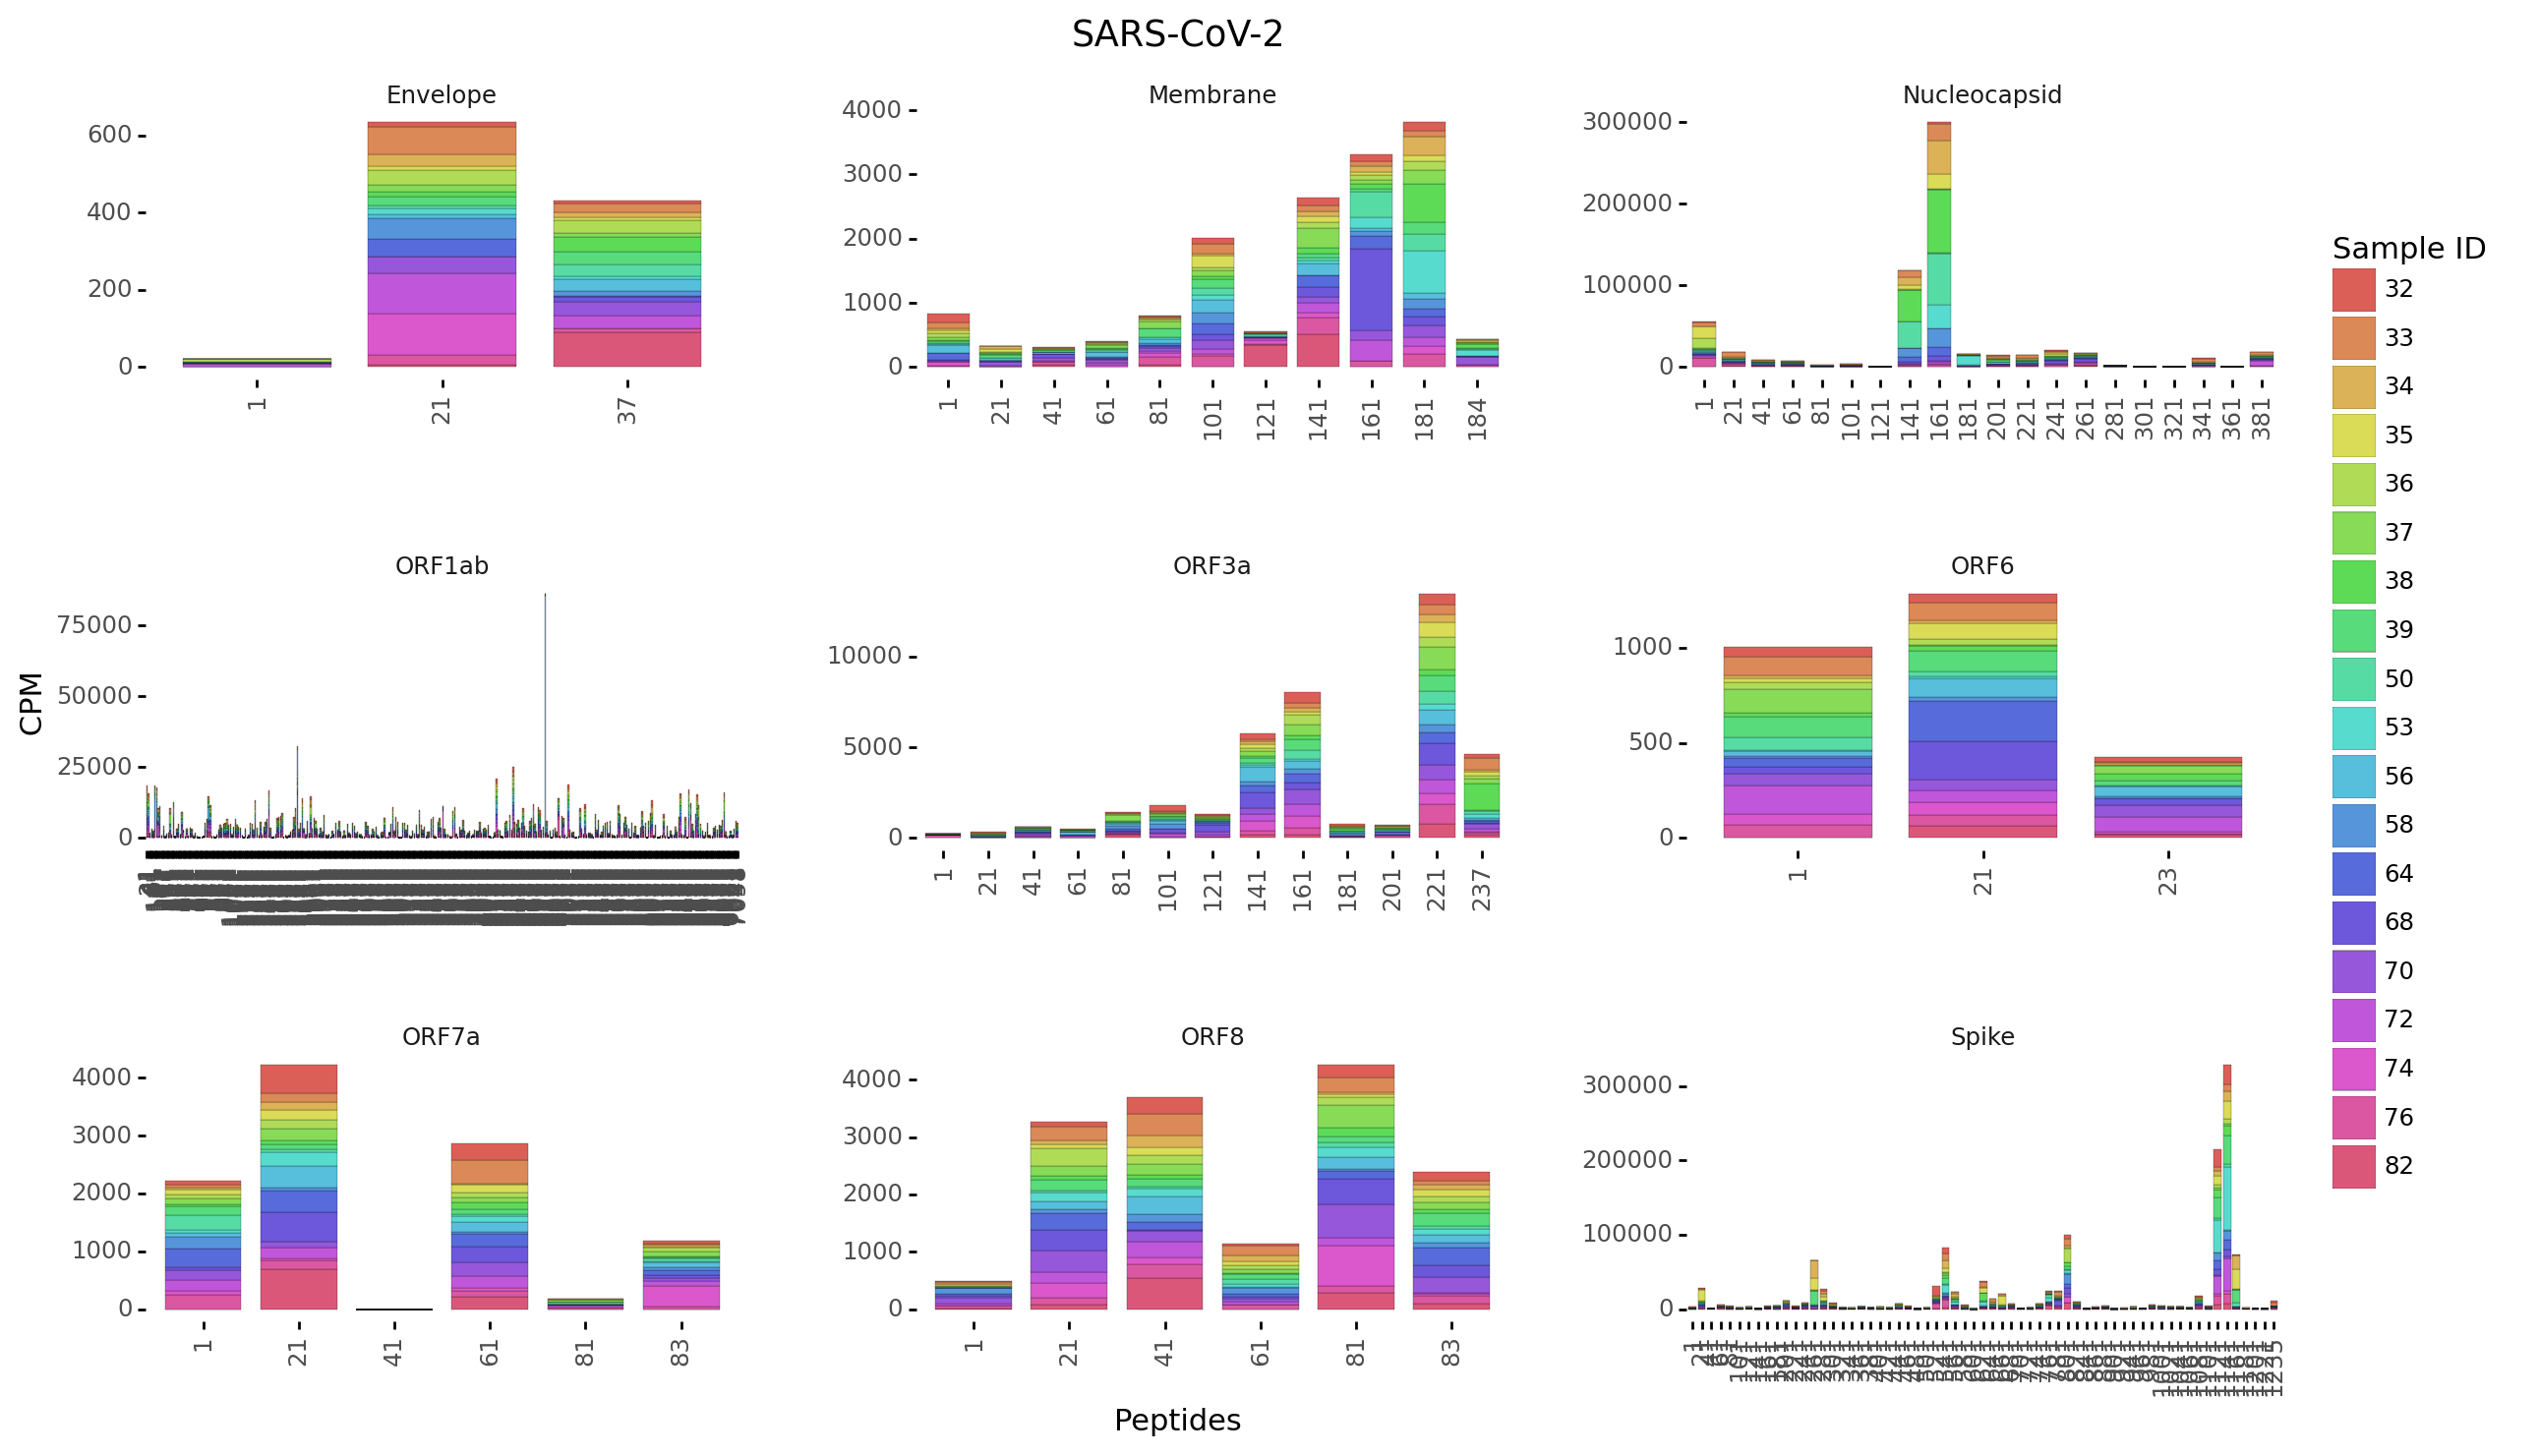

In [8]:
all_enrichments_tidy = pd.concat(tidy.values()).reset_index()
all_enrichments_tidy = all_enrichments_tidy[all_enrichments_tidy["Virus"] == "SARSCoV2"]
all_enrichments_tidy = all_enrichments_tidy[all_enrichments_tidy["Protein"] != "ORF10_protein"]

all_avg_bio_reps = all_enrichments_tidy.groupby(
    ["sample_ID", "peptide_id", "Virus", "Protein", "patient_status", "Prot_Start"]
).mean().reset_index()

f = ( 
    ggplot(all_avg_bio_reps)
    + aes(x = "factor(Prot_Start)", y = 'cpm', fill="sample_ID") 
    + geom_col(colour="black", size=0.05, show_legend=True, width=0.8)
    + facet_wrap(
        "~Protein",
        nrow=3,
        ncol=3,  
        scales="free",
        as_table=True
    )
    + theme_bw()
    + theme( 
        axis_text_x=element_text(rotation=90, linespacing=1.0),
        figure_size=[14,8], 
        subplots_adjust={'wspace': 0.30, 'hspace' : 0.75},
        panel_background=element_blank(),
        strip_background=element_blank(),
        panel_grid = element_blank()
        
    )
    + labs(
        title = "SARS-CoV-2",
        y=" CPM\n",
        x="Peptides",
        fill = "Sample ID"
    )
)
f.draw()
f.save(f"{plots_csv_basedir}/SARS-CoV-2-profile-stack-col.pdf")

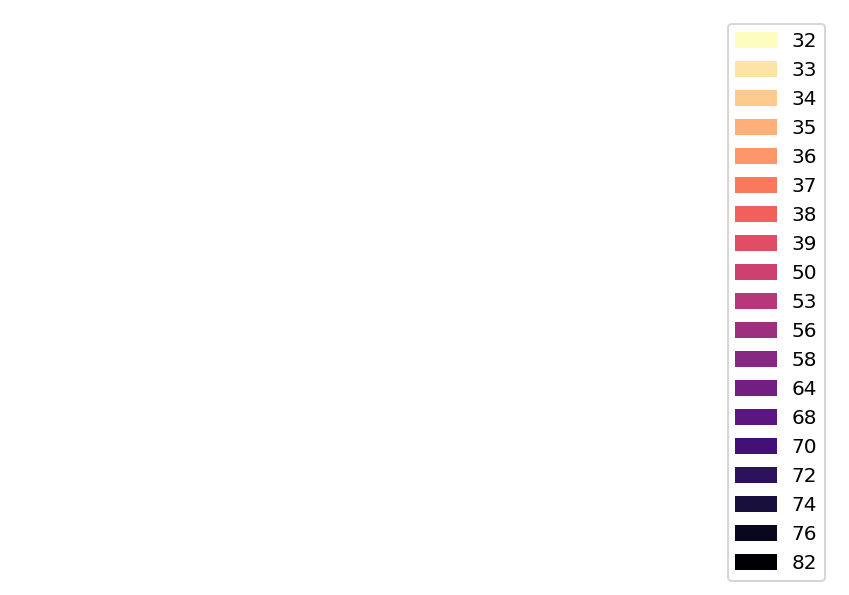

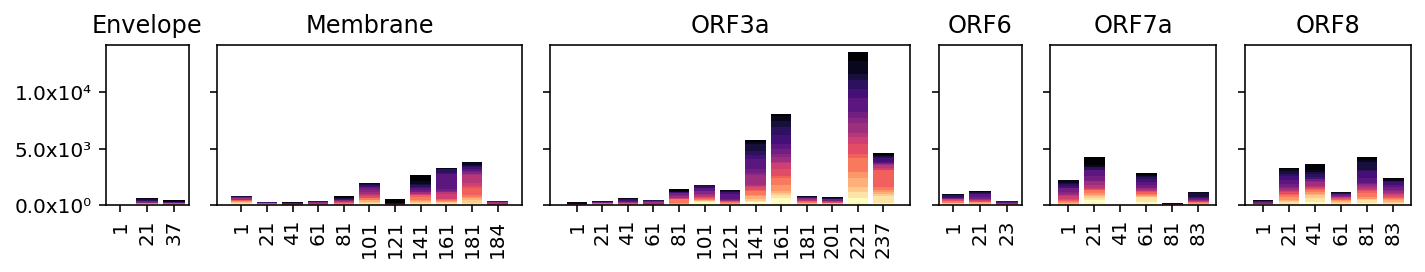

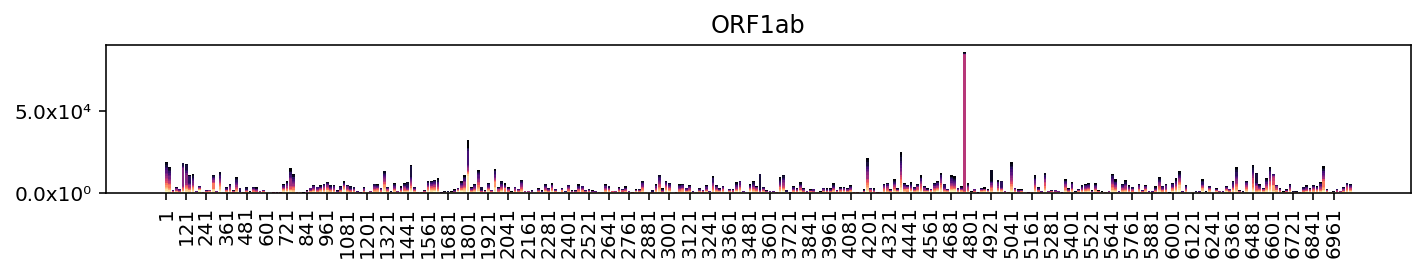

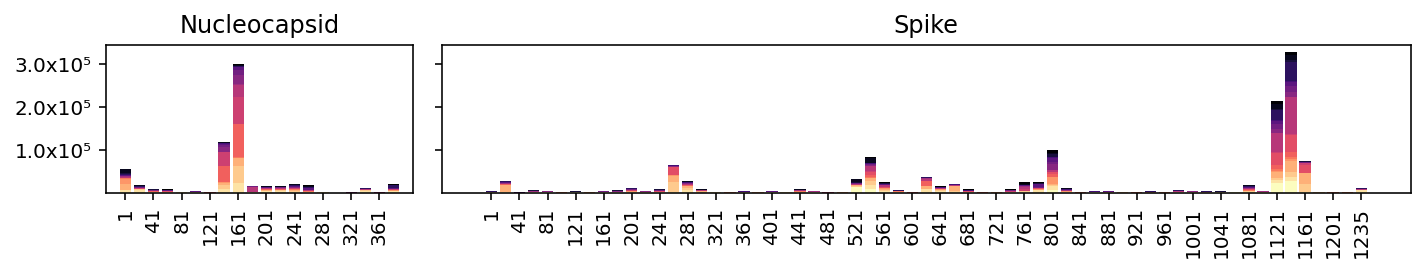

In [9]:
samples = sorted(list(set(all_avg_bio_reps["sample_ID"])))
color_map = cm.get_cmap("magma", len(samples))
sample_color_map = {sam:col for sam, col in zip(samples, color_map.colors[::-1])}

palette = dict(zip(sample_color_map.keys(), sample_color_map.values()))
handles = [mpl.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
plt.legend(handles=handles)
plt.gca().set_axis_off()
plt.tight_layout()
plt.savefig(f"{plots_csv_basedir}/" + "cpm_legend.pdf", pad_inches= 1.0, bbox_inches='tight')

def SuperScriptinate(number):
    return number.replace('0','⁰').replace('1','¹').replace('2','²').replace('3','³').replace('4','⁴').replace('5','⁵').replace('6','⁶').replace('7','⁷').replace('8','⁸').replace('9','⁹').replace('-','⁻')

def y_fmt(x, y):
    initial = '{:1.1e}'.format(x)
    a,b = initial.split("e")
    b = int(b)
    return a + "x10" + SuperScriptinate(str(b)) 

proteins_per_row = [
    ["Envelope","ORF6", "ORF7a", "ORF8", "Membrane","ORF3a"], 
    ["ORF1ab"],
    ["Nucleocapsid", "Spike"]
]

for row_index, row_proteins in enumerate(proteins_per_row): 
    
    all_avg_bio_reps_row = all_avg_bio_reps[all_avg_bio_reps["Protein"].isin(row_proteins)]
    ratios = [len(set(prot_df["peptide_id"])) for prot, prot_df in all_avg_bio_reps_row.groupby("Protein")]
    
    fig, ax = plt.subplots(
        1, len(row_proteins), 
        figsize=[10,2], 
        gridspec_kw={'width_ratios': ratios}, 
        sharey=True
    )
    
    if len(row_proteins) == 1: ax = [ax]
    for subplot_index, (protein, protein_df) in enumerate(all_avg_bio_reps_row.groupby("Protein")):
        
        col_bottoms = np.zeros(len(set(protein_df["Prot_Start"])))
        ax[subplot_index].set_title(protein)
                                    
        for sample_ID, protein_sample_df in protein_df.groupby("sample_ID"):
                                    
            prot_start_factors = [str(ps) for ps in protein_sample_df['Prot_Start']]
            sample_heights = protein_sample_df["cpm"].values

            ax[subplot_index].bar(
                prot_start_factors,
                sample_heights,
                bottom = col_bottoms,
                color = sample_color_map[sample_ID],
                label = sample_ID
            )

            col_bottoms += sample_heights
            
        ax[subplot_index].tick_params(labelrotation=90, axis="x")
        ax[subplot_index].yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
        if protein == "ORF1ab": ax[subplot_index].set_xticks(prot_start_factors[::6])
        if protein == "Spike": ax[subplot_index].set_xticks(prot_start_factors[::2])
        if protein == "Nucleocapsid": ax[subplot_index].set_xticks(prot_start_factors[::2])

    name = "".join(row_proteins)
    plt.tight_layout()
    plt.show()     
    fig.savefig(f"{plots_csv_basedir}/" + "-".join(row_proteins)+".pdf")


In [10]:
all_megsub_control_peptides = set(tidy["MEGSUB"][tidy["MEGSUB"]["Virus"]=="HIV1"]["peptide_id"])
all_sub2_control_peptides = set(tidy["SUB2"][tidy["SUB2"]["Virus"]=="HIV1"]["peptide_id"])
assert(len(all_megsub_control_peptides) == len(all_sub2_control_peptides))

# total number of control peptides
N_c = len(all_megsub_control_peptides) * len(set(tidy["MEGSUB"]["sample_id"]))

unique_peptides = defaultdict(list)
for num_ranked_peptides in range(1, len(tidy["MEGSUB"])-1):
    for library in tidy:
        
        # melt the libraries and find the tail peptides with thresh num_ranked_peptides
        melted = tidy[library]
        rank_threshold = (len(melted)-1) - num_ranked_peptides
        all_peptides_in_tail = melted[melted[f"{metric}_rank_table"] > rank_threshold]

        
        # find the control peptides within the tail of the dist
        control_peptides = all_peptides_in_tail[all_peptides_in_tail["Virus"] == "HIV1"]
        
        # add how many unique bio samples contain controls at this point. 
        all_bio_samples = set(control_peptides["sample_ID"])
        unique_peptides[f"{library}_n_bio_samples_w_control"].append(len(all_bio_samples))
        
        # add control ratio
        unique_peptides[f"{library}_cr"].append(len(control_peptides)/N_c)
        
    unique_peptides["num_ranked_included"].append(num_ranked_peptides)
 
    # if we've passed the fpr of interest, stop adding peptides.
    if (unique_peptides[f"MEGSUB_cr"][-1] > (fpr+0.01) and unique_peptides[f"SUB2_cr"][-1] > (fpr+0.01)): break

unique_ranked_peptides = pd.DataFrame(unique_peptides)

In [11]:
melt_pep = pd.melt(unique_ranked_peptides, id_vars=["num_ranked_included"])

In [12]:
# respective rank cutoff for each library batch
megsub_rank_cutoff = 0
for i, num_ranked in unique_ranked_peptides.iterrows():
    if num_ranked["MEGSUB_cr"] > fpr:
        megsub_rank_cutoff = num_ranked["num_ranked_included"]
        break
for i, num_ranked in unique_ranked_peptides.iterrows():
    if num_ranked["SUB2_cr"] > fpr:
        sub2_rank_cutoff = num_ranked["num_ranked_included"]
        break
#print(f"the total number of ranked peptides is: {len(unique_ranked_peptides)}")
print(f"The rank cutoff for megsub at {fpr}: {megsub_rank_cutoff}")
print(f"The rank cutoff for sub2 at {fpr}: {sub2_rank_cutoff}")

The rank cutoff for megsub at 0.05: 2689.0
The rank cutoff for sub2 at 0.05: 4604.0


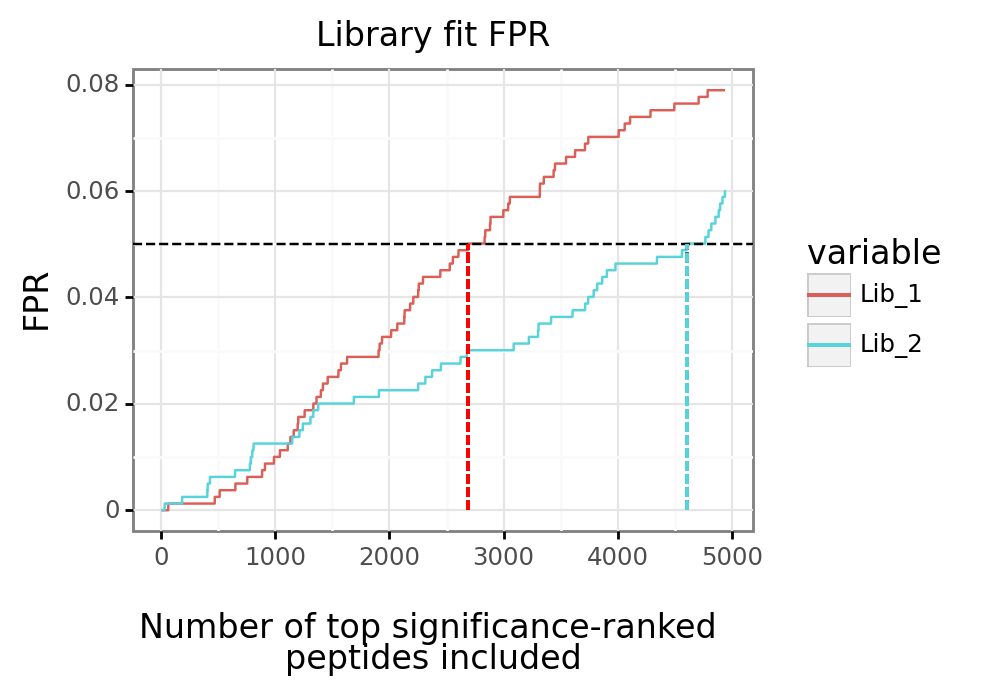

In [13]:
cr = melt_pep[melt_pep["variable"].isin(["MEGSUB_cr","SUB2_cr"])]
cr["variable"][cr["variable"] == "MEGSUB_cr"] = "Lib_1"
cr["variable"][cr["variable"] == "SUB2_cr"] = "Lib_2"
f =(
  ggplot(cr, aes(x="num_ranked_included", y="value", group="variable", color="variable"))
    + geom_line()
    + labs(
        title="Library fit FPR",
        y="FPR",
        x="\nNumber of top significance-ranked \npeptides included"
    )
    + theme_bw()
    + theme(
        title=element_text(size=12), 
        figure_size=[4,3]
    )
    + geom_hline(yintercept=fpr, linetype="dashed", color = "black")
    + geom_segment(aes(x=megsub_rank_cutoff, y=0, xend=megsub_rank_cutoff, yend=fpr), color="r", linetype="dashed")
    + geom_segment(aes(x=sub2_rank_cutoff, y=0, xend=sub2_rank_cutoff, yend=fpr), linetype="dashed")
)
f.draw()
f.save(f"{plots_csv_basedir}/FDR_cr_full.pdf")

In [14]:
# compute batch "hits".
batch_hits = {}
for library, rank_cutoff in zip(library_batches, [megsub_rank_cutoff, sub2_rank_cutoff]):
    
    # the df's created by Curation-Analysis.ipynb
    #lib_ds = pickle.load(open(f"single-bio-rep-{library}.phip","rb"))
    #print(lib_ds.peptide_metadata)
    lib_ds = fit_batch_ds[library]
    
    valid_patient_status = sample_id_coordinate_subset(
        lib_ds, where="patient_status", is_valid=True
    )
    
    # slice the dataset to cut out all bead samples
    lib_cov_pos_ds = lib_ds.loc[
        dict(
            sample_id = valid_patient_status,
            sample_metadata=["library_batch", "sample_ID", "patient_status"],
            peptide_metadata=["Virus", "Protein", "Prot_Start", "Prot"]
        )
    ]

    # rank by our favorite metric
    rank_data_table(lib_cov_pos_ds, data_table=metric, new_table_name=f"{metric}_rank_table")
    melted = tidy_ds(lib_cov_pos_ds)
    rank_threshold = (len(melted)-1) - rank_cutoff
    
    # Get all the hits above some threshold
    
    lib_hits = melted[melted[f"{metric}_rank_table"] > rank_threshold].reset_index()
    batch_hits[f"{library}"] = lib_hits
    uniq_lib_hits = len(set(lib_hits["peptide_id"]))
    print(f"{library}: There are {len(lib_hits)} hits, for {uniq_lib_hits} unique peptides")
    



# assert there is only a single "hit" per library
for lib in library_batches:
    for bio_id, bio_df in batch_hits[lib].groupby("sample_ID"):
        for peptide_id, bio_peptide_df in bio_df.groupby("peptide_id"):
            assert len(bio_peptide_df) == 1

# all hits between both libraries
all_batch_hits = pd.concat(batch_hits.values()).reset_index()

# find all common "Hits"
shared_hit_ids = []
for bio_id, bio_df in all_batch_hits.groupby("sample_ID"):
    for peptide_id, bio_peptide_df in bio_df.groupby("peptide_id"):
        if len(bio_peptide_df) == 2:
            shared_hit_ids.extend(bio_peptide_df.index.values)
shared_hits_df = all_batch_hits.loc[shared_hit_ids,:]

# reduce by averaging all numeric columns and preserving the rest
avg_bio_reps = shared_hits_df.groupby(
    ["sample_ID", "peptide_id", "Virus", "Protein", "patient_status", "Prot", "Prot_Start"]
).mean().reset_index()

# make a new column, counts of all sample appearence for each peptide id.
peptide_hits_counts = avg_bio_reps.groupby("peptide_id").count()
phc = peptide_hits_counts["sample_ID"].reset_index().rename(columns ={"sample_ID":"n_samples_count"})
hits_df = avg_bio_reps.merge(phc, on="peptide_id").drop(["level_0", "index"], axis=1)

# lastly, let's add a column that groups all SARS-CoV-2 positive/negative patients
cv_pos = ["acute inpatient", "conv outpatient 30d"]
hits_df["SARS-CoV-2 infection"] = ["-" for _ in range(len(hits_df))]

# How do I do this without a warning?
hits_df["SARS-CoV-2 infection"][hits_df["patient_status"].isin(cv_pos)] = "+"

hits_df.to_csv(f"./hits_df.csv", index=False, na_rep="NA")

MEGSUB: There are 2689 hits, for 1598 unique peptides
SUB2: There are 4604 hits, for 2479 unique peptides


In [15]:
total_hits = len(hits_df)
unique_peptides = len(set(hits_df["peptide_id"]))
unique_sequences = len(set(hits_df["Prot"]))
print(f"There are {total_hits} total hits across individuals and {unique_peptides} unique peptides, {unique_sequences} unique sequences")

There are 933 total hits across individuals and 456 unique peptides, 417 unique sequences


In [16]:
pos_hits = len(hits_df[hits_df["SARS-CoV-2 infection"]=="+"])
neg_hits = len(hits_df[hits_df["SARS-CoV-2 infection"]!="+"])
print(f"there are \n{pos_hits} hits from covid positive patients, and \n{neg_hits} hits from covid negative patients")

there are 
815 hits from covid positive patients, and 
118 hits from covid negative patients


In [17]:
for pat_st, pat_st_df in hits_df.groupby("patient_status"):
    print(pat_st)
    print(sorted(list(set(pat_st_df["sample_ID"])))[::-1])

acute inpatient
['35', '34', '33', '32']
conv outpatient 30d
['82', '76', '74', '72', '70', '68', '64', '58', '56', '53', '50', '39', '38', '37', '36']
endemic CoV (HAARVi inpatient)
['182']
endemic CoV, HRV
['183']
healthy adult
['45', '44', '43', '41']


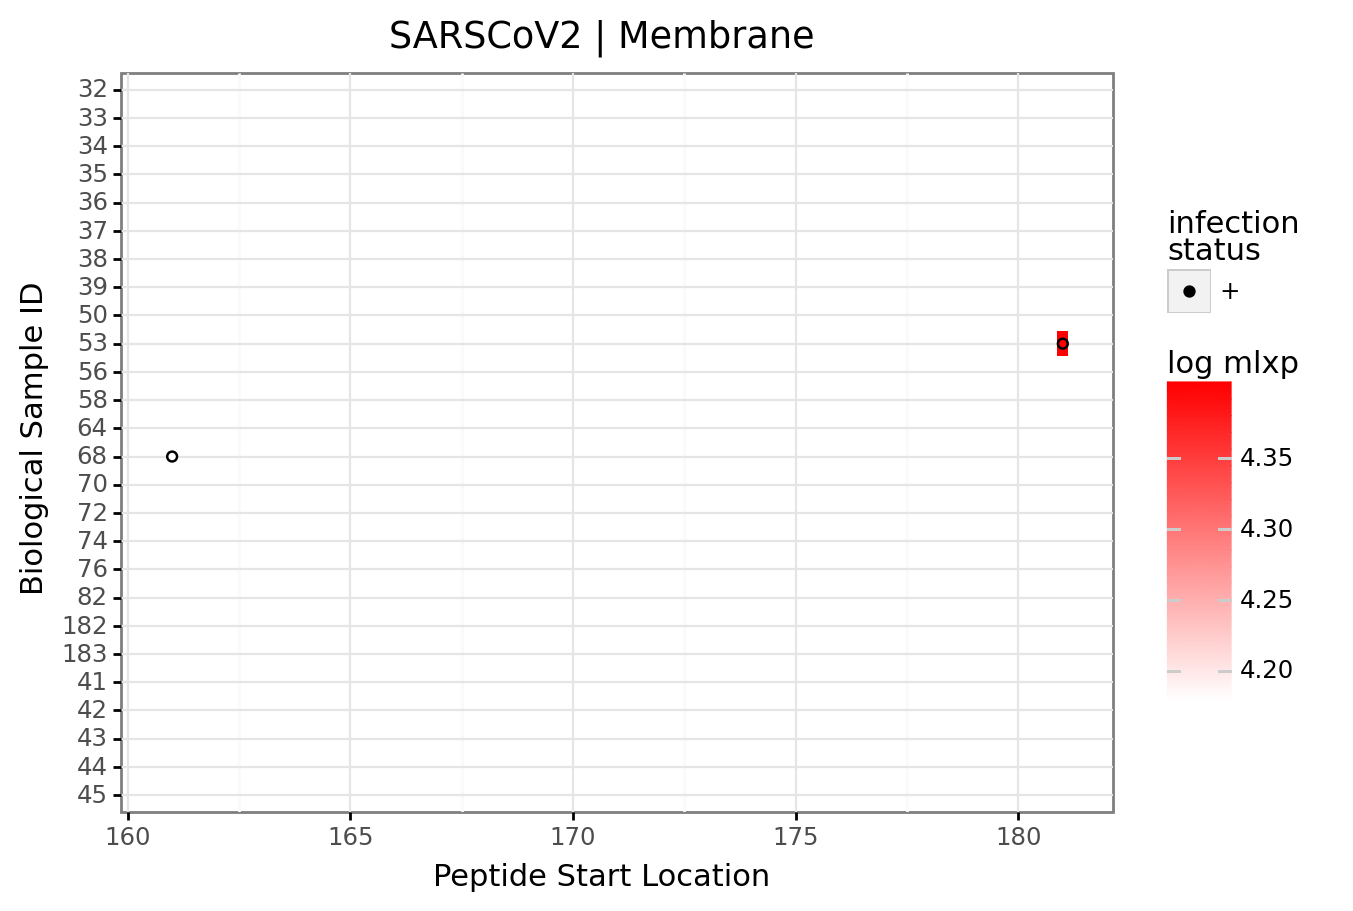

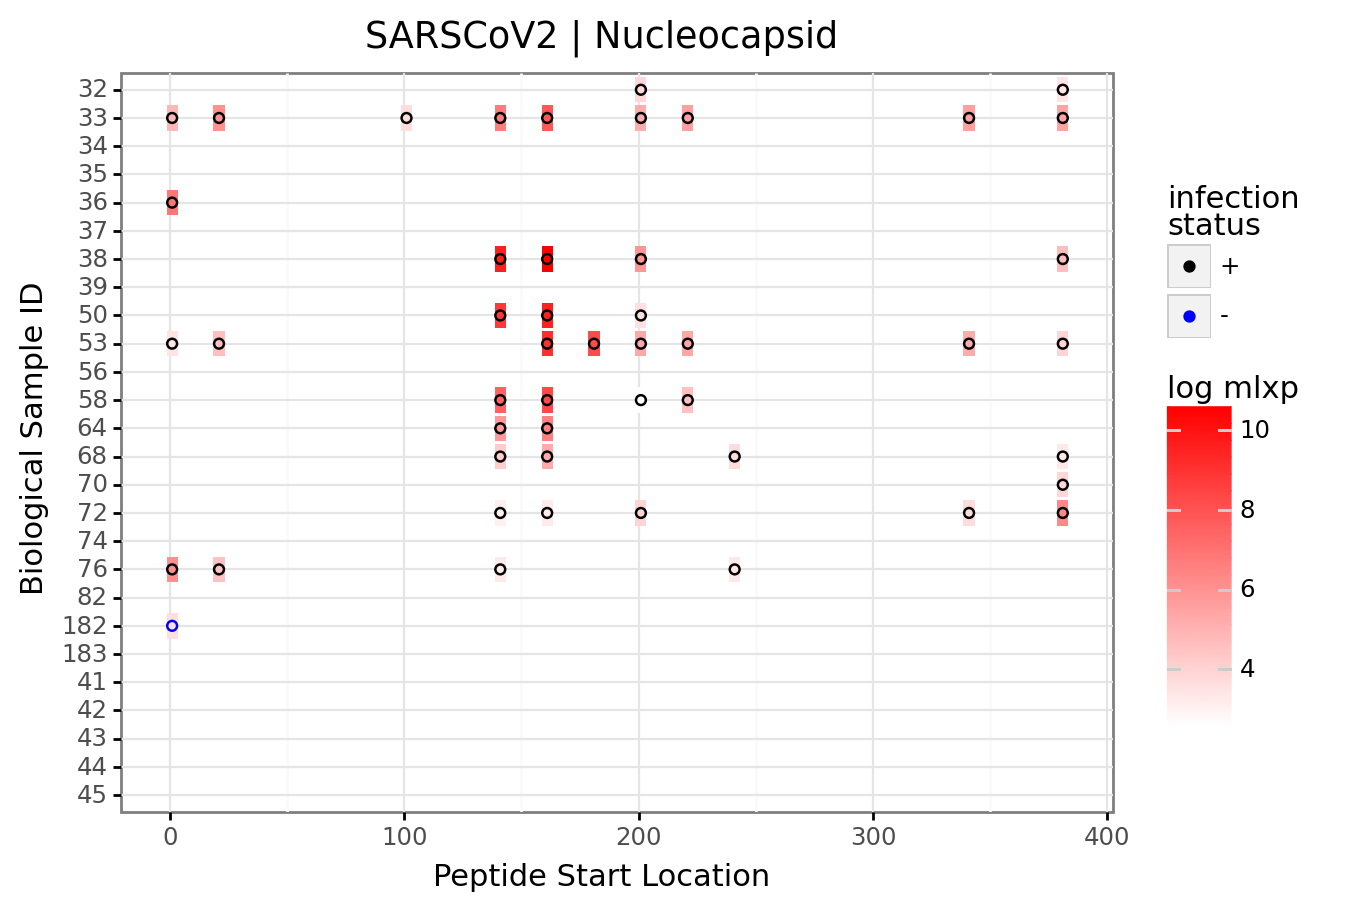

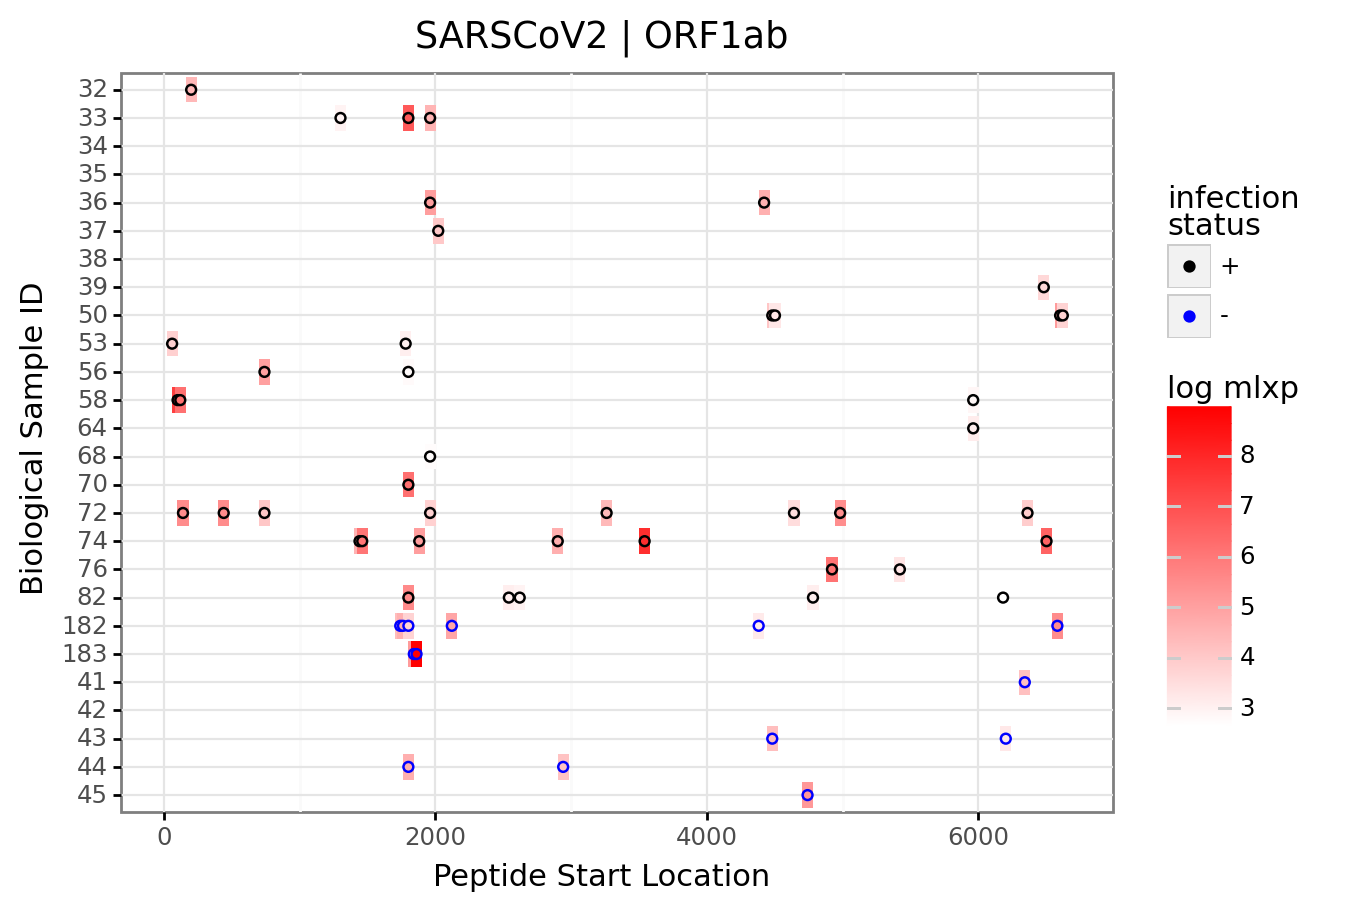

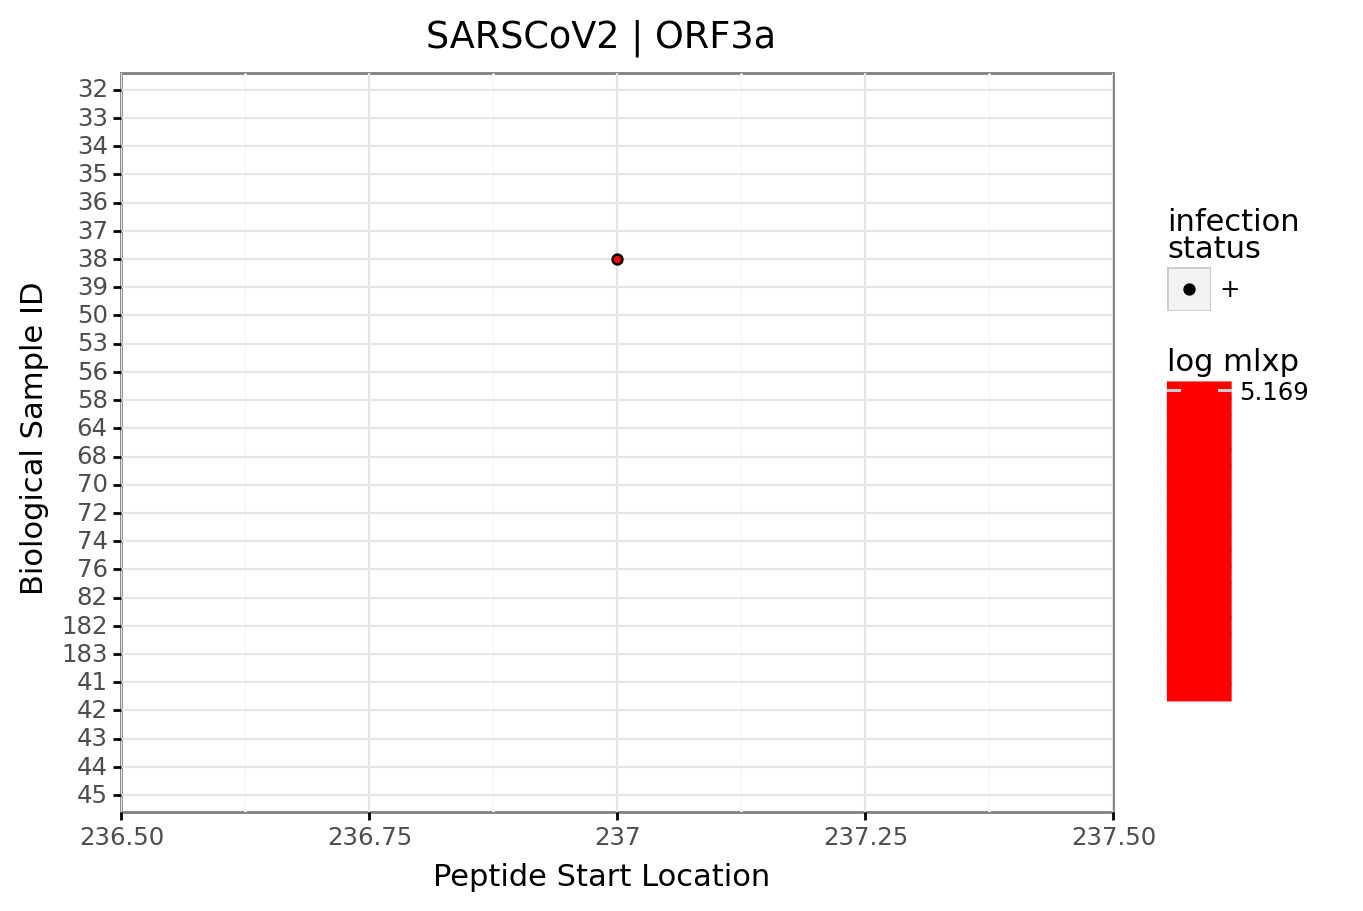

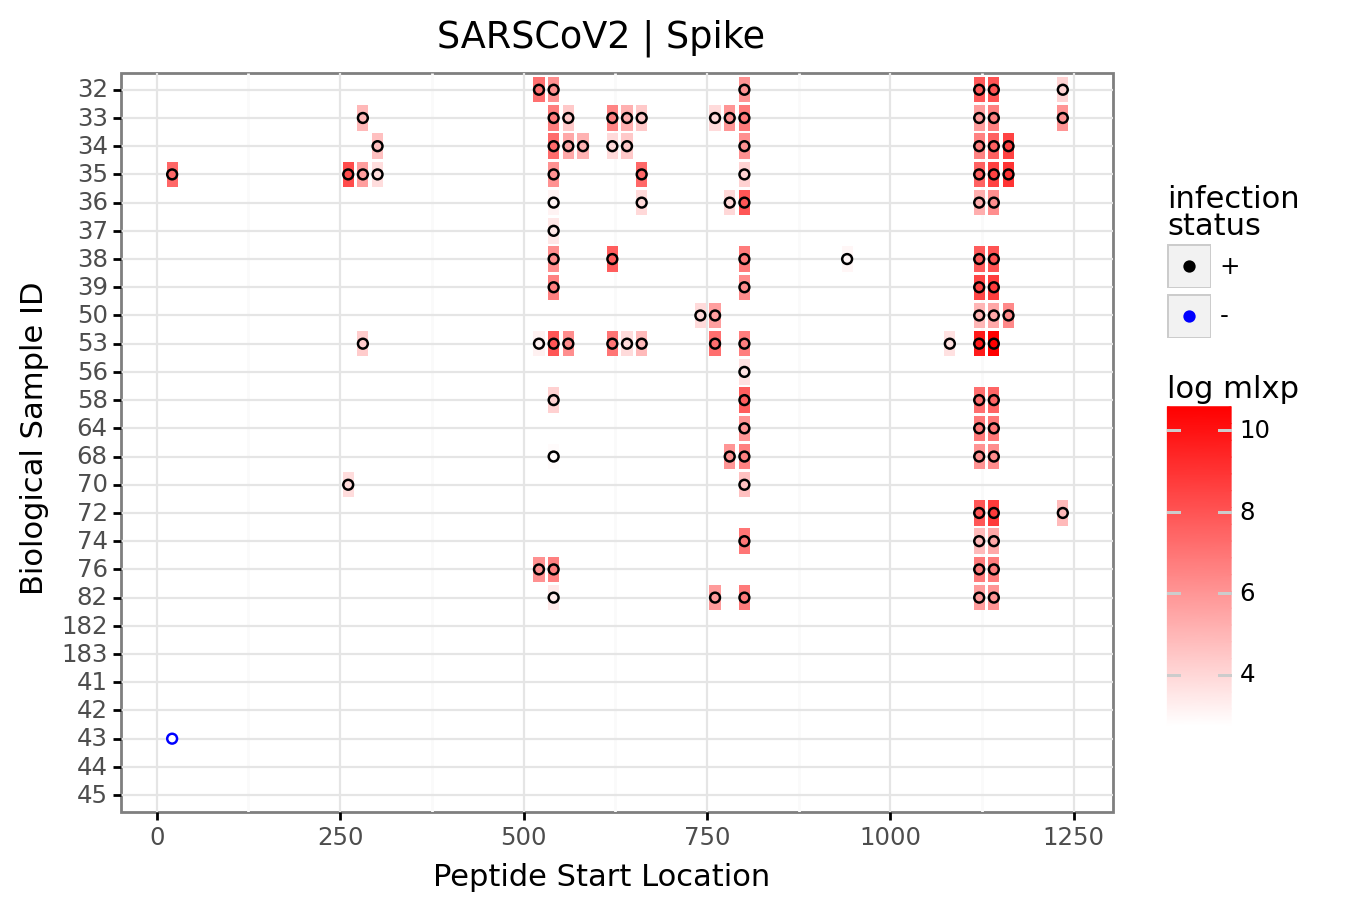

In [18]:
sample_order = ['45', '44', '43', '42','41',
                '183', '182',
                '82', '76', '74', '72', '70', '68', '64', '58', '56', '53', '50', '39', '38', '37', '36',
                '35', '34', '33', '32']

plotdir=f"{plots_csv_basedir}/hits_heatmaps_4"
if not os.path.exists(plotdir): os.mkdir(plotdir)
for virus, virus_df in hits_df.groupby("Virus"):
    virus_base_dir = os.path.join(plotdir,virus)
    if not os.path.exists(virus_base_dir): os.mkdir(virus_base_dir)
    for protein, protein_df in virus_df.groupby("Protein"):
        
        n_locations = max(protein_df["Prot_Start"]) - min(protein_df["Prot_Start"])
        wid = n_locations / 80

        f = (
            ggplot(protein_df) 
            + aes(
                x="Prot_Start", 
                y="sample_ID", 
                fill="np.log(gamma_poisson_mlxp_size_factors)",
                height=0.9,
                width=wid
            )
            + geom_tile()
            + geom_point(aes(color="SARS-CoV-2 infection")) 
            + scale_size_manual(values=[15,15])
            + scale_color_manual(values=["black","blue"])
            + theme(
                figure_size=[12,5], 
                subplots_adjust={'wspace': 0.08},
                plot_background=element_rect(fill='white')
            )
            + scale_fill_gradient(low="white", high="red", name="")
            + theme_bw()
            + labs(
                title=f"{virus} | {protein}",
                x = "Peptide Start Location",
                y = "Biological Sample ID",
                fill="log mlxp",
                color="infection\nstatus\n"
            )
            + scale_y_discrete(limits=sample_order)
        )
        save_to = os.path.join(virus_base_dir,f"{protein}.pdf")
        f.save(os.path.join(virus_base_dir,f"{protein}.pdf"))
        if virus=="SARSCoV2": f.draw()


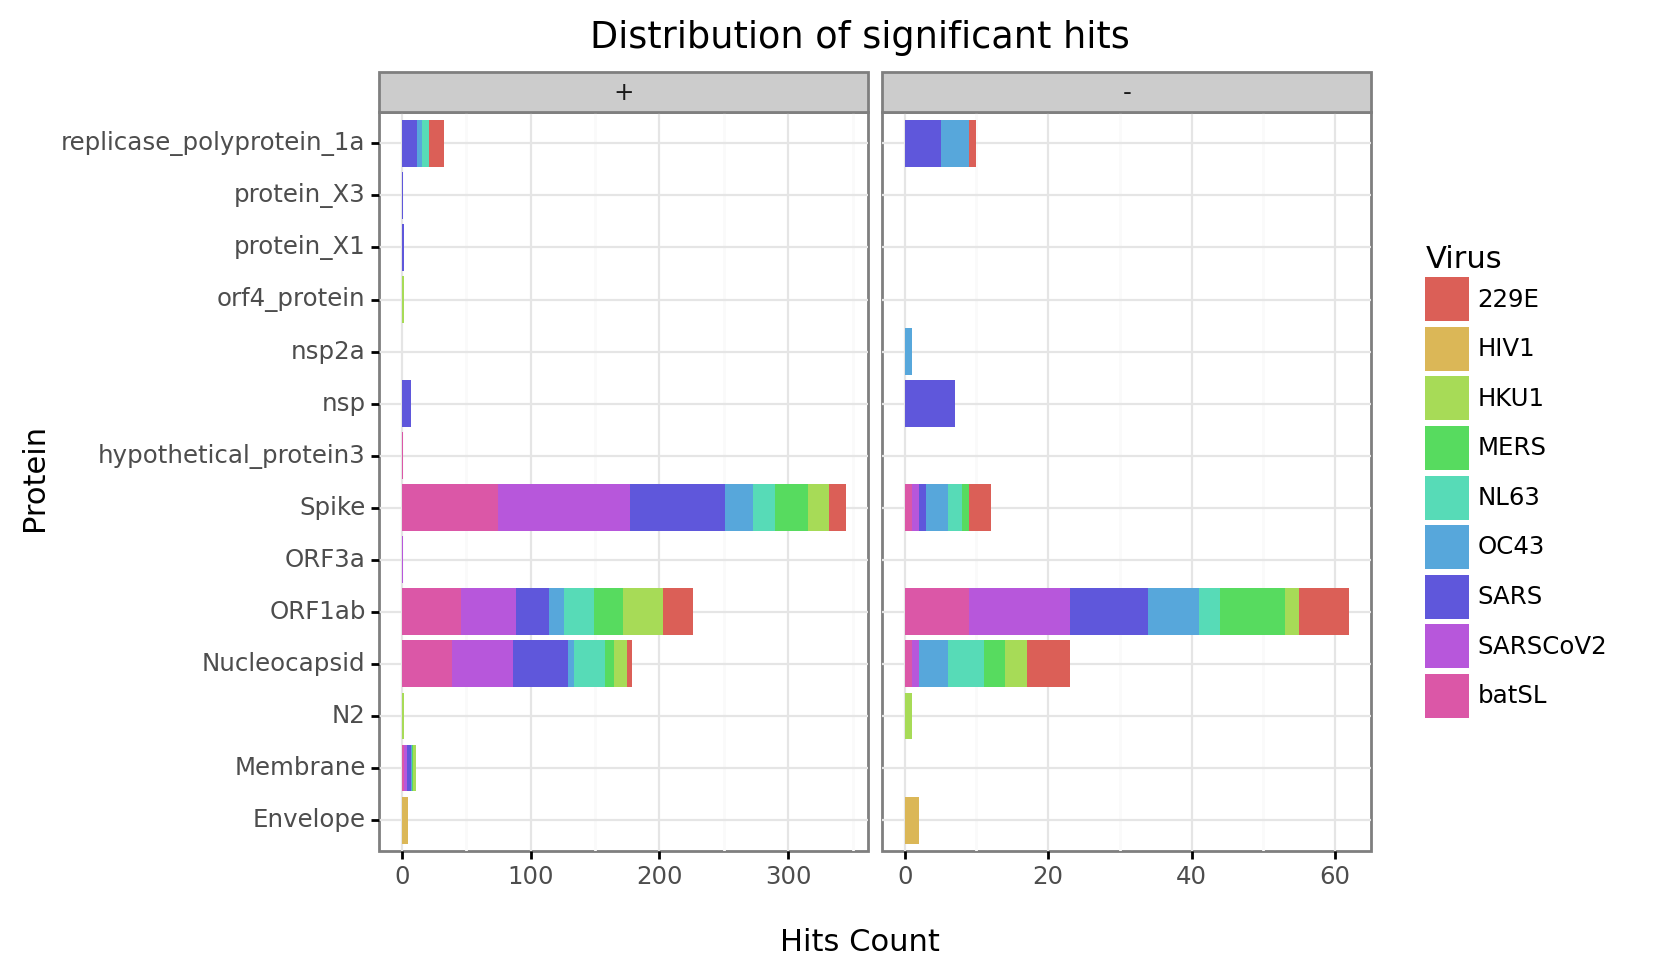

In [19]:
all_unique_peptides = set(hits_df["peptide_id"])
    
f = (
    ggplot(hits_df, aes(x='Protein', fill="Virus"))
    + geom_col(stat="count")
    + labs(
        title = f"Distribution of significant hits",
        y=f"\nHits Count"
    )
    + facet_wrap("SARS-CoV-2 infection", scales="free_x")
    + theme(
        axis_text_x=element_text(rotation=90), 
        figure_size=[10,6], 
        subplots_adjust={'wspace': 0.10, 'hspace' : 0.35})
    + coord_flip()
    + theme_bw()
)
f.draw()
f.save(f"{plots_csv_basedir}/stacked_facet_ps.pdf")

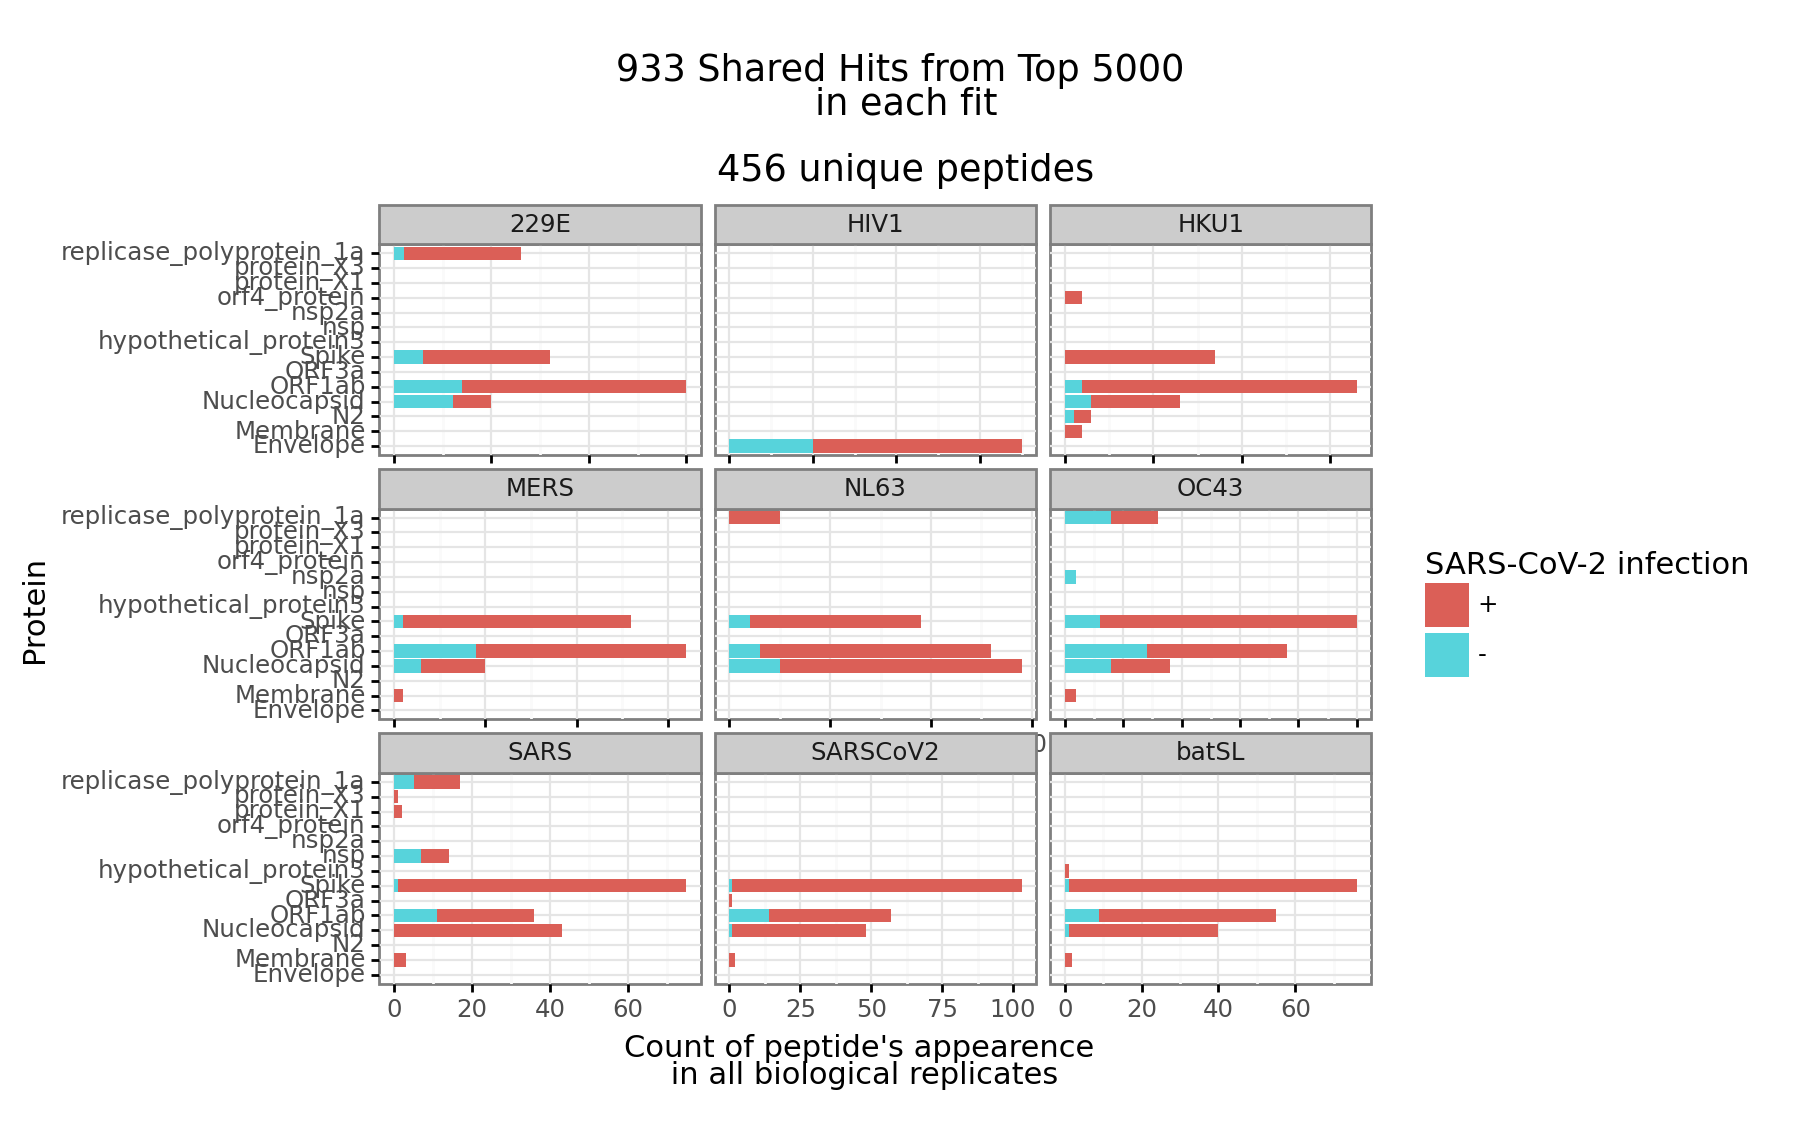

In [20]:
all_unique_peptides = set(hits_df["peptide_id"])
    
f = (
    ggplot(hits_df, aes(x='Protein', fill="SARS-CoV-2 infection", group="SARS-CoV-2 infection"))
    + geom_bar(stat="count")
    + labs(
        title = f"""
        {len(shared_hits_df)//2} Shared Hits from Top 5000 
        in each fit\n
        {len(all_unique_peptides)} unique peptides""",
        y=f"Count of peptide's appearence\n in all biological replicates\n"
    )
    + facet_wrap("~Virus", scales="free_x")
    + theme(
        axis_text_x=element_text(rotation=90), 
        figure_size=[10,8], 
        subplots_adjust={'wspace': 0.10, 'hspace' : 0.35})
    + coord_flip()
    + theme_bw()
)
f.draw()
f.save(f"{plots_csv_basedir}/stacked_facet_vi.pdf")

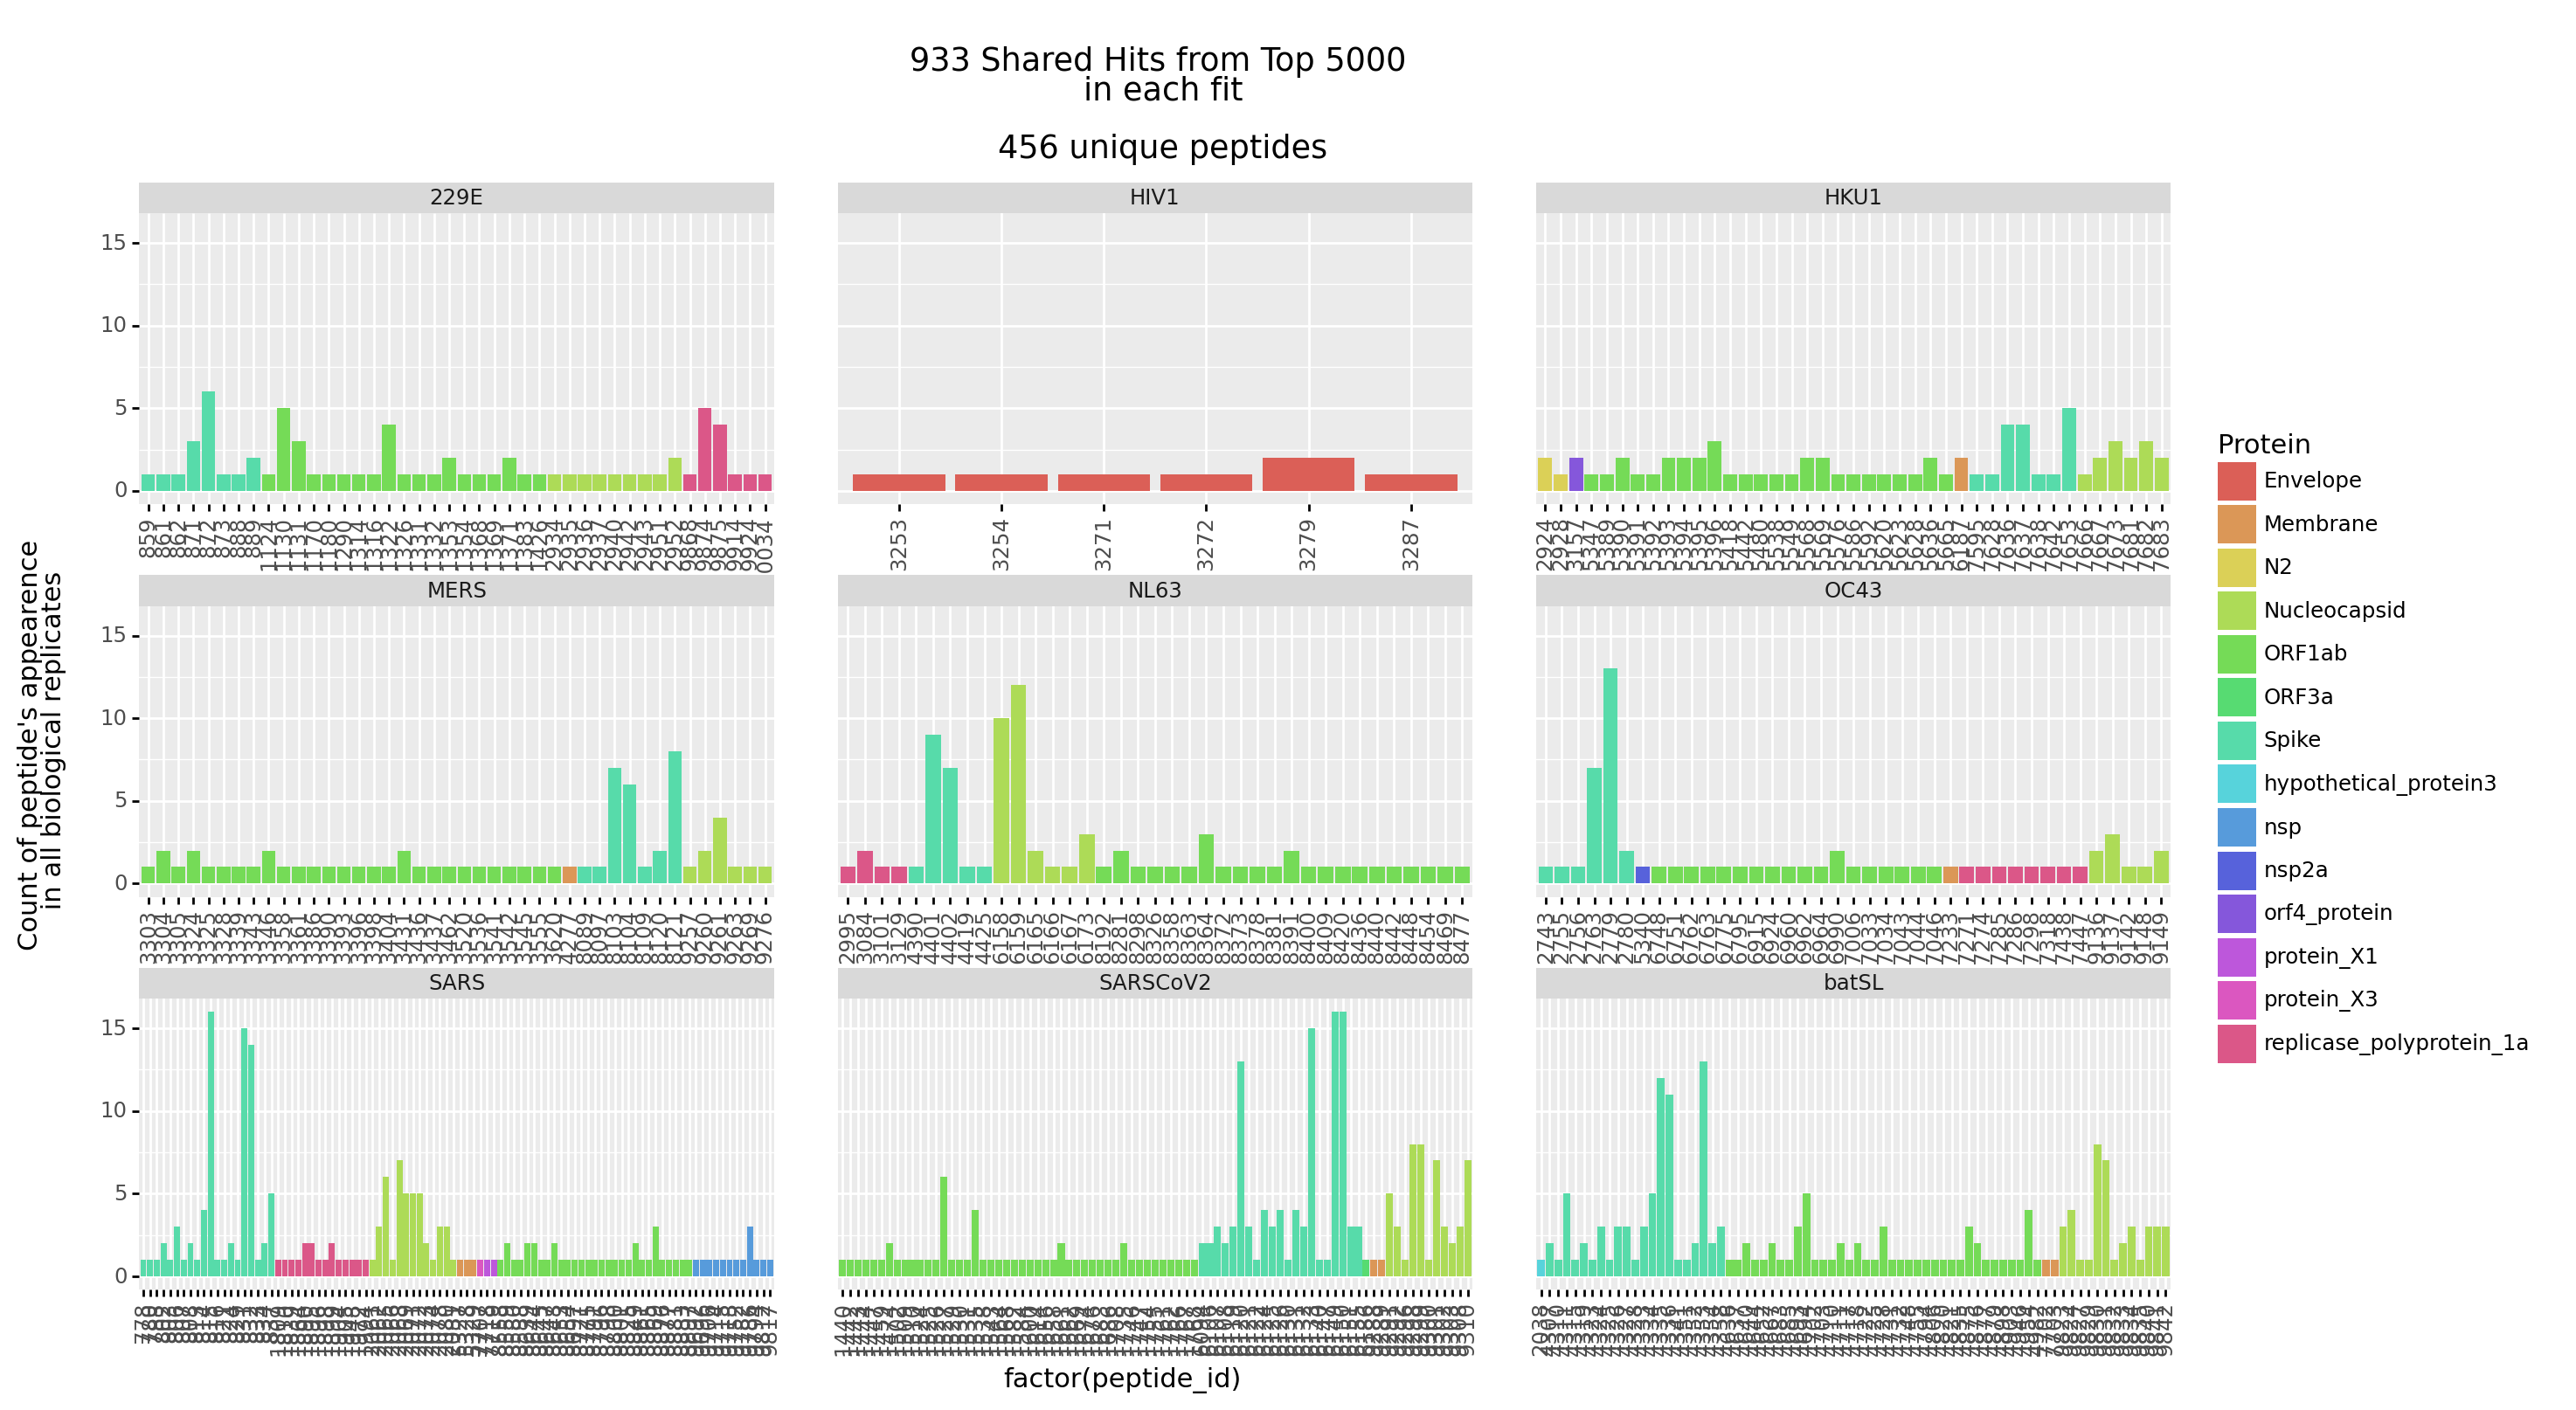

In [21]:
all_unique_peptides = set(hits_df["peptide_id"])
    
f = (
    ggplot(hits_df, aes(x='factor(peptide_id)', fill="Protein"))
    + geom_col(stat="count")
    + labs(
        title = f"""
        {len(avg_bio_reps)} Shared Hits from Top 5000 
        in each fit\n
        {len(all_unique_peptides)} unique peptides""",
        y=f"Count of peptide's appearence\n in all biological replicates\n"
    )
    + facet_wrap("~Virus", scales="free_x")
    + theme(
        axis_text_x=element_text(rotation=90), 
        figure_size=[15,8], 
        subplots_adjust={'wspace': 0.10, 'hspace' : 0.35})
)
f.draw()
f.save(f"{plots_csv_basedir}/sample_counts.pdf")

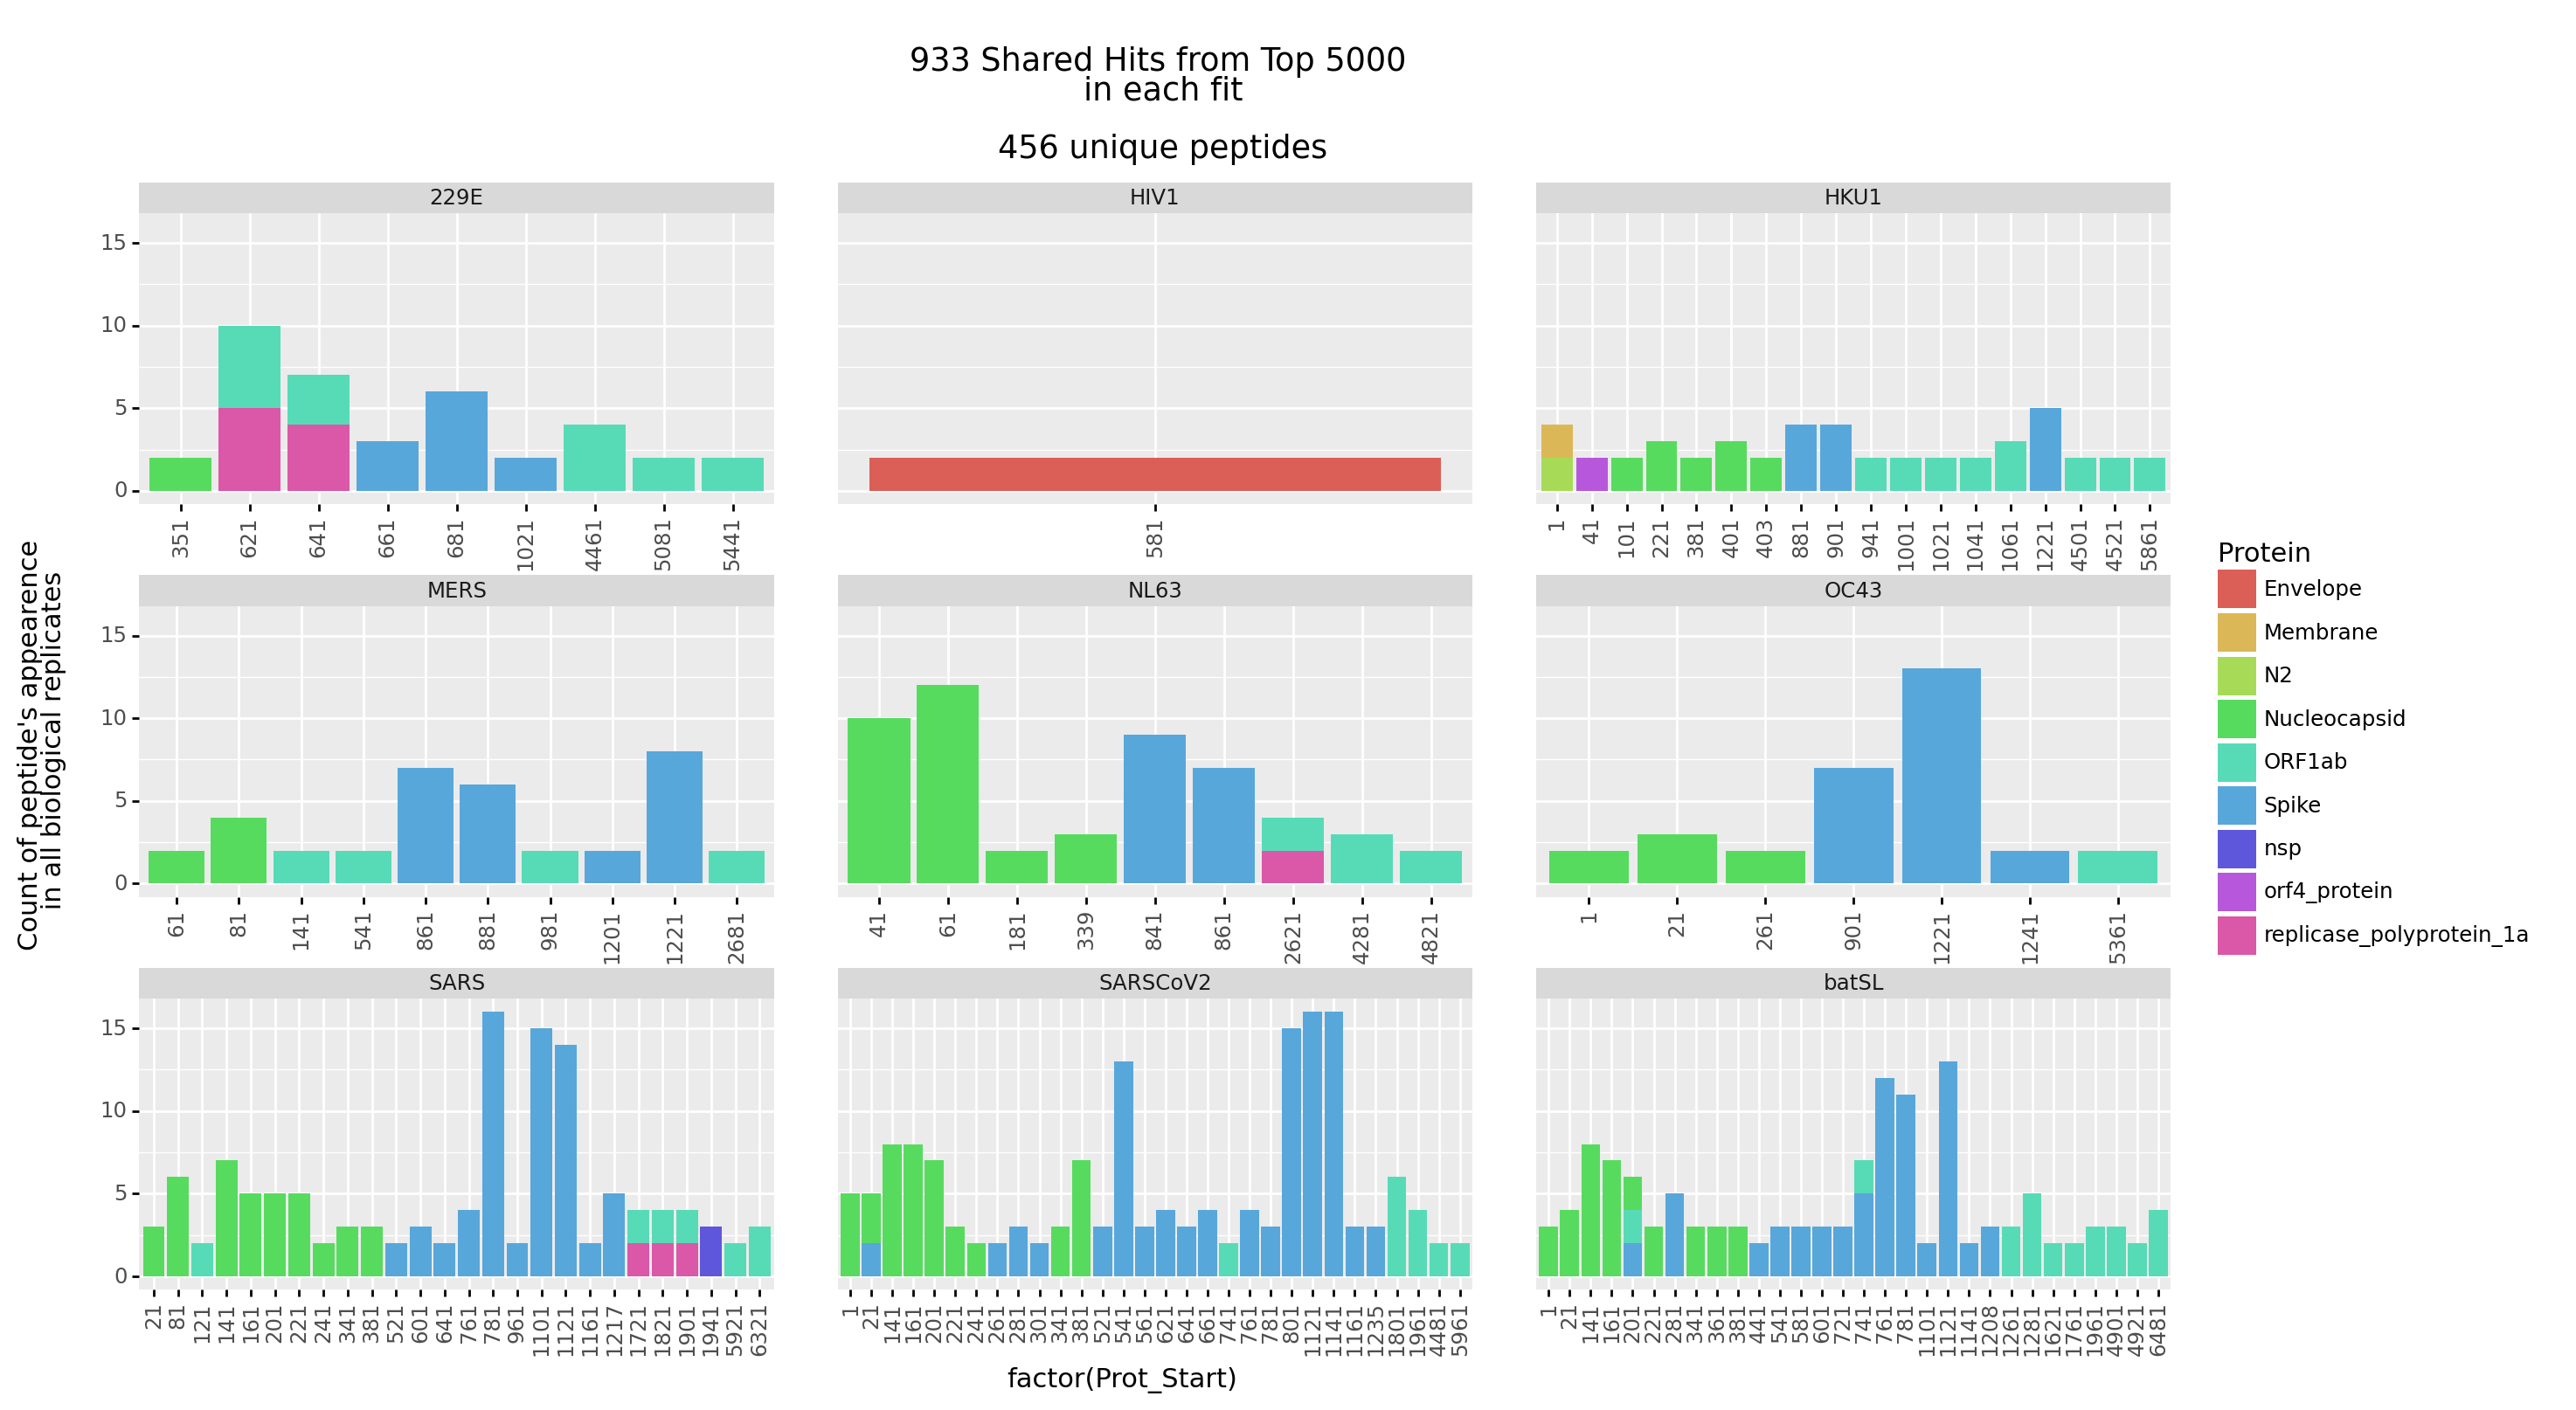

In [22]:
all_unique_peptides = set(hits_df["peptide_id"])
    
f = (
    ggplot(hits_df[hits_df["n_samples_count"]>=2], aes(x='factor(Prot_Start)', fill="Protein"))
    + geom_col(stat="count")
    + labs(
        title = f"""
        {len(avg_bio_reps)} Shared Hits from Top 5000 
        in each fit\n
        {len(all_unique_peptides)} unique peptides""",
        y=f"Count of peptide's appearence\n in all biological replicates\n"
    )
    + facet_wrap("~Virus", scales="free_x")
    + theme(
        axis_text_x=element_text(rotation=90), 
        figure_size=[15,8], 
        subplots_adjust={'wspace': 0.10, 'hspace' : 0.35})
)
f.draw()
f.save(f"{plots_csv_basedir}/sample_counts_above_2.pdf")